In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

#const
k = 1.3806504e-23
hb = 1.0545716e-34
h = (2.0*np.pi*1.0545716e-34) 
c = 2.9979246e+8
#some functions
def readSp(specName, delimiter):
    x = np.array([])
    y = np.array([])
    with open(specName, newline='') as f:
        fr = csv.reader(f, delimiter=delimiter, quotechar='|')
        ii = 0
        for row in fr:
            ii += 1
            if ii > 33 and ii < 3682:
                y = np.append(y, row[1])
                x = np.append(x, row[0])
                #print(y, x)
    x = x.astype(np.float)
    y = y.astype(np.float)
    out = np.array([[1,1]])
    ii = -1
    for _ in x:
        ii += 1
        out = np.append(out, [[x[ii],y[ii]]], axis = 0)
    out = out[1:]
    return out

def intSp(spec, unit, intTime):
    n = unit / (intTime * 1e-3)
    return np.trapz(spec[:,1] * n , spec[:,0] * 1e-9)

def intSp1(spec, unit, intTime):
    n = unit / (intTime * 1e-3)
    return np.trapz(spec[:,1] * n * spec[:,0]* 1e-9, spec[:,0] * 1e-9)

def qEff(abs1, abs2, intFl1, intFl2, n1 = 1, n2 = 1, qeff1 = 0.95):
    return qeff1 * (intFl2/intFl1) * (abs1/abs2) * (n2/n1) ** 2

def func(x, a, b, c, d, e, f):
     return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 
    
def transM(y, x, trans):
    tx = trans[:, 0]
    ty = trans[:, 1]

    #f = np.vectorize(lambda zz: min(tx, key=lambda z:abs(z-zz)))
    #x1 = f(x)
    #f = np.vectorize(lambda z: np.where(tx == z)[0][0])
    #ind = f(x1)
    #f = np.vectorize(lambda z: ty[z])
    #y1 = f(ind)
    #y11 = y / y1
    #y = y11 / max(y11)
        
    xmin = min(np.where(tx >= min(x))[0])
    xmax = max(np.where(tx <= max(x))[0])
    tx1 = tx[xmin:xmax]
    ty1 = ty[xmin:xmax]
    popt, pcov = curve_fit(func, tx1, 1/ty1)
    y1 = func(x,*popt)
    y1 = (y1 > 0) * y1
    y = y * y1
    y = y 
    
    return y,x

def avgPlot(xIn, yIn, num):
    while yIn.size%num != 0:
        yIn = yIn[1:]
        xIn = xIn[1:]
    yOut = np.mean(yIn.reshape(-1, num), axis=1)
    xOut = np.mean(xIn.reshape(-1, num), axis=1)
    error = np.std(yIn.reshape(-1, num), axis=1)
    return xOut, yOut, error

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

#smoothing
def smooth(x, y, downwl, upwl):
    down = np.where(x >= downwl)[0][0]
    up = np.where(x <= upwl)[0][-1]
    #ysmooth = savitzky_golay(y[down:up], 101, 3)
    ysmooth = savitzky_golay(y[down:up], 81, 2)
    #ysmooth = savitzky_golay(y[down:up], 51, 1)
    yOut = np.copy(y)
    yOut[down:up] = ysmooth
    return yOut

def cleanSpec(spec, dwV = 525, upwV = 530, dwV1 = 535, upwV1 = 540):
    specdata2 = np.copy(spec)
    upw = np.where(specdata2[:,0] >= upwV)[0][0] 
    dw = np.where(specdata2[:,0] <= dwV)[0][-1] 

    upw1 = np.where(specdata2[:,0] >= upwV1)[0][0] 
    dw1 = np.where(specdata2[:,0] <= dwV1)[0][-1] 
    
    wl = np.concatenate((specdata2[dw:upw,0], specdata2[dw1:upw1,0]))
    val = np.concatenate((specdata2[dw:upw,1], specdata2[dw1:upw1,1]))
    
    popt, pcov = curve_fit(func, wl, val)

    specdata2[upw:dw1,1] = func(specdata2[upw:dw1,0],*popt)
    return specdata2

In [2]:
absorbtionH = np.log(1385/230)/10
print(absorbtionH)
absorbtionL = np.log(1385/528)/10
print(absorbtionL)

qdfluor = readSp('MIT_qd1/qd1_f_2_avg5.csv',';')
qdfluor1 = readSp('MIT_qd1/qd1_f_2_avg10.csv',';')
qdfluor2 = readSp('MIT_qd1/qd1_f_2_avg50.csv',';')

r6gfluorH = readSp('rd6_f_22_2e-6.csv', ';')
r6gfluorL = readSp('rd6_f_22_1e-6.csv', ';')

#fig, ax = plt.subplots(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(fluor[:,0], fluor[:,1]/max(fluor[:,1]), linestyle='', marker='o', color='green')
#ax.plot(fluor1[:,0], fluor1[:,1]/max(fluor1[:,1]), linestyle='', marker='o', color='red')
#ax.plot(fluor2[:,0], fluor2[:,1]/max(fluor2[:,1]), linestyle='', marker='o', color='blue')
#plt.xlim(595, 600)

#print(intSp(qdfluor, 0.125, 170))
#print(intSp(qdfluor1, 0.125, 170))
#print(intSp(qdfluor2, 0.125, 170))

qdintFluor = intSp(fluor, 0.125, 170)
r6gintFluorH = intSp(r6gfluorH, 0.125, 211)
r6gintFluorL = intSp(r6gfluorL, 0.125, 211)

absorbtion1 = np.log(1525/477)/0.01
#first
absorbtionH = np.log(1385/230)/0.01
absorbtionL = np.log(1385/528)/0.01
#pulsed meas
#absorbtionH = np.log(480/142)/0.01
#absorbtionL = np.log(480/202)/0.01
#constant
#absorbtionH = np.log(580/88)/0.01
#absorbtionL = np.log(580/190)/0.01
#absorbtionH = np.log(430/275)/0.002
#absorbtionL = np.log(430/360)/0.002
absorbtionH = np.log(105/74)/0.002
absorbtionL = np.log(109/84)/0.002

absorbtionH = 92 - 14.90
absorbtionL = 92 - 32.2

absorbtionH = np.log(92/14.90)/0.002
absorbtionL = np.log(92/32.2)/0.002
#32.2
#14.90
#91.20 - 92

#print(absorbtion3)

qeff2 = qEff(absorbtionH,absorbtionL, r6gintFluorH, r6gintFluorL)
print(qeff2)

0.17953761096982435
0.09643591349151773


FileNotFoundError: [Errno 2] No such file or directory: 'rd6_f_22_2e-6.csv'

pure 6.458125539202384e-09 4.920577755361346e-09 1.8960364092013293e-09
processed 7.3526761965554635e-09 5.603063486603197e-09 2.159016747434185e-09
processed 7.322573244582342e-09 5.5809855400423055e-09 2.1429692670320333e-09
processed 7.322339384486863e-09 5.580764285022921e-09 2.142744397055696e-09
A from osc 1.3770176571720167 0.7976013983061143 0.2238112567328233
A from spec  1.4493055706068958 0.7979389567522013 0.2828571711489254
A from osc new 1.0051631767574265 0.6319165961248074 0.06558753108589409
A from osc new2 1.3361660592500655 0.655228142364193 0.07505920814965994
A from osc new3 1.3761417280395178 0.7387551846957761 0.07600810364931287
A from osc new3_ 1.3761417280395178 0.7387551846957761 0.11808057450444016
A from osc new 4 0.9349515190058909 0.40153141558406097 0.279548086219595 0.7515489401462856 0.33604923411616283 0.26779792991797563 0.48213853350662594
a from osc new 5 [0.75045201 0.90824298 0.90202383 1.36975605 1.80486601 2.59902182]
a from osc new 6 [0.034385

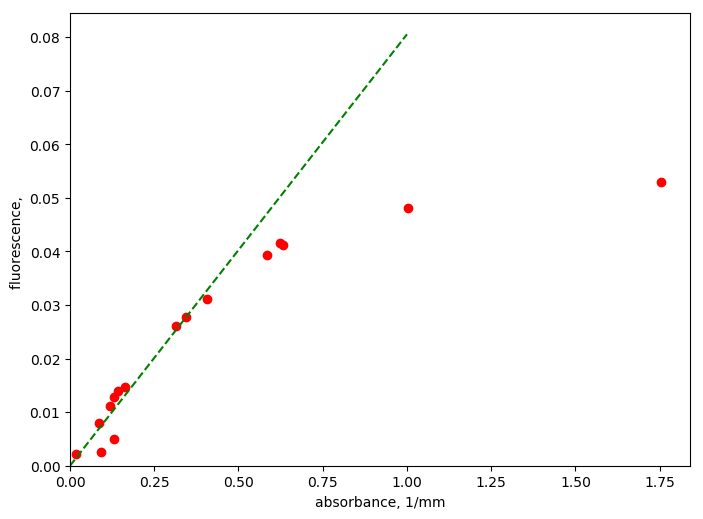

In [5]:
qdfluor1 = readSp('MIT_qd1/qd1_fluor/1.csv',';')
qdfluor2 = readSp('MIT_qd1/qd1_fluor/2.csv',';')
qdfluor3 = readSp('MIT_qd1/qd1_fluor/3.csv',';')

qdintFluor1 = intSp(qdfluor1, 0.075, 409)
qdintFluor2 = intSp(qdfluor2, 0.075, 409)
qdintFluor3 = intSp(qdfluor3, 0.075, 409)
print('pure', qdintFluor1, qdintFluor2, qdintFluor3)

#transmition
qdfluor1[:,1], qdfluor1[:,0] = transM(qdfluor1[:,1] * 100, qdfluor1[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))
qdfluor2[:,1], qdfluor2[:,0] = transM(qdfluor2[:,1] * 100, qdfluor2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))
qdfluor3[:,1], qdfluor3[:,0] = transM(qdfluor3[:,1] * 100, qdfluor3[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))

qdintFluor1 = intSp(qdfluor1, 0.075, 409)
qdintFluor2 = intSp(qdfluor2, 0.075, 409)
qdintFluor3 = intSp(qdfluor3, 0.075, 409)
print('processed', qdintFluor1, qdintFluor2, qdintFluor3)

#get rid of pump
qdfluor1 = cleanSpec(qdfluor1)
qdfluor2 = cleanSpec(qdfluor2)
qdfluor3 = cleanSpec(qdfluor3)

qdintFluor1 = intSp(qdfluor1, 0.075, 409)
qdintFluor2 = intSp(qdfluor2, 0.075, 409)
qdintFluor3 = intSp(qdfluor3, 0.075, 409)

print('processed', qdintFluor1, qdintFluor2, qdintFluor3)
#smoothing
qdfluor1[:,1] = smooth(qdfluor1[:,0], qdfluor1[:,1], 480, 620)
qdfluor2[:,1] = smooth(qdfluor2[:,0], qdfluor2[:,1], 480, 620)
qdfluor3[:,1] = smooth(qdfluor3[:,0], qdfluor3[:,1], 480, 620)

qdintFluor1 = intSp(qdfluor1, 0.075, 409)
qdintFluor2 = intSp(qdfluor2, 0.075, 409)
qdintFluor3 = intSp(qdfluor3, 0.075, 409)

print('processed', qdintFluor1, qdintFluor2, qdintFluor3)

#power
#1.796 2.81
#0.566 2.79
#0.170 2.67

p3 = abs(1.796 - 2.81)
p2 = abs(0.566 - 2.79)
p1 = abs(0.170 - 2.67)

p3 = -np.log(1.796/2.81)/2
p2 = -np.log(0.566 /2.79)/2
p1 = -np.log(0.170 / 2.67)/2
print('A from osc', p1, p2, p3)
#obtained A from specs for absorption
p3 = 0.2828571711489254 
p2 = 0.7979389567522013 
p1 = 1.4493055706068958
print('A from spec ', p1, p2, p3)

#diff from specs 

#p = 0.07753127810000002 
p3 = 0.13114115590000003 
p2 = 0.24199950321000002 
p1 = 0.2868106663

#new meas
p3 = -np.log(47.8/54.5)/2
p2 = -np.log(15.4/54.5)/2
p1 = -np.log(7.3/54.5)/2
print('A from osc new', p1, p2, p3)

#new meas
p3 = -np.log(142/165)/2
p2 = -np.log(44.5/165)/2
p1 = -np.log(11.4/165)/2
print('A from osc new2', p1, p2, p3)

#new meas
p3 = -np.log(134/156)/2
p2 = -np.log(35.6/156)/2
p1 = -np.log(9.95/156)/2
print('A from osc new3', p1, p2, p3)

#new meas
p3 = -np.log(47.16/153.6)/10
p2 = -np.log(35.6/156)/2
p1 = -np.log(9.95/156)/2
print('A from osc new3_', p1, p2, p3)

#new meas
p3 = -np.log((162/222)/(280.8/220))/2
p2 = -np.log((125.2/218)/(271.8/212))/2
p1 = -np.log((42.06/212)/(260/202))/2
p_4 = -np.log((60.66/214)/(277.8/218))/2
p_6 = -np.log((145.3/220)/(274.2/212))/2
p_2 = -np.log((157.1/212)/(268.4/212))/2
p_3 = -np.log((96.88/216)/(249.4/212))/2

print('A from osc new 4', p1, p2, p3, p_4, p_6, p_2, p_3)

#new meas
pAL = np.array([428, 195.7, 174.4, 182.8, 116.8, 74.11, 33.16])
p0 = np.array([190, 184, 192, 200, 204, 200, 198])
pL = -np.log((pAL[1:]/p0[1:])/((pAL[0]/p0[0])))
print('a from osc new 5', pL)
qdintFluorL = np.array([1.04/184, 1.76/192, 1.76/200, 3.44/204, 4.4/200, 5.2/198]) 

#new meas
pAL = np.array([277.5, 271.9,234.2,220.4, 246.4,242.5,237.4,233.5,223.1,171.3,160.5,142.6,
               99.35,89.34,89.83,41.73,9.594])
p0 = np.array([219.9, 223,223.3,227,232,244.3,244.9,245.8,244.4,254.5,253.3,254.7,254,
               245.5,252.7,245.5,253])
pL = -np.log((pAL[1:]/p0[1:])/((pAL[0]/p0[0])))
qdintFluorL = np.array([0.5,0.560,1.120,1.840,2.720,3.120,3.440,3.6,6.64,7.04,7.920,
                        10,10.2,10.4,11.8,13.4]) 

qdintFluorL = qdintFluorL#/p0[1:]

print('a from osc new 6', pL)
#meas from spectrometer
qdintFluorL = np.array([qdintFluor1, qdintFluor2, qdintFluor3/2])

#new measurement 

qdintFluorL = np.array([19.75 / 231, 19.4 / 235.9, 4.94 / 241])

#new measurement 

qdintFluorL = np.array([5.189 / 238.1, 3.410 / 236, 2.477 / 236.6])
qdintFluorL = np.array([5.189 / 238.1, 3.410 / 236, 2.477 / 236.6, 4.174/217.9, 
                        2.623/223.8, 2.143/202, 3.529/210])

p3 = -np.log((162/222)/(280.8/220))/2
p2 = -np.log((125.2/218)/(271.8/212))/2
p1 = -np.log((42.06/212)/(260/202))/2
p_4 = -np.log((60.66/214)/(277.8/218))/2
p_6 = -np.log((145.3/220)/(274.2/212))/2
p_2 = -np.log((157.1/212)/(268.4/212))/2
p_3 = -np.log((96.88/216)/(249.4/212))/2

#(303/250)

pL = np.array([p1,p2,p3,p_4,p_6, p_2, p_3])

pL = -np.log((pAL[1:]/p0[1:])/((pAL[0]/p0[0])))
qdintFluorL = np.array([1.04/184, 1.76/192, 1.76/200, 3.44/204, 4.4/200, 5.2/198]) 

pAL = np.array([277.5, 271.9,234.2,220.4, 246.4,242.5,237.4,233.5,223.1,171.3,160.5,142.6,
               99.35,89.34,89.83,41.73,9.594])
p0 = np.array([219.9, 223,223.3,227,232,244.3,244.9,245.8,244.4,254.5,253.3,254.7,254,
               245.5,252.7,245.5,253])
pL = -np.log((pAL[1:]/p0[1:])/((pAL[0]/p0[0])))/2
qdintFluorL = np.array([0.5,0.560,1.120,1.840,2.720,3.120,3.440,3.6,6.64,7.04,7.920,
                        10,10.2,10.4,11.8,13.4]) 

qdintFluorL = qdintFluorL/p0[1:]

#qdintFluorL = qdintFluorL * 100
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
ax.errorbar(pL[:], qdintFluorL[:], fmt='-o', linestyle='', color='red')

k = qdintFluorL / pL

print('relations', k)

def funcc(x,  b):
    return   b * x
popt, pcov = curve_fit(funcc, pL[:-8]  , qdintFluorL[:-8])
print('coeff', popt)

pp = np.linspace(0, 1, num=5)
ax.errorbar(pp, funcc(pp, *popt), fmt='', linestyle='--', color='green')
plt.xlim(0,)

plt.ylabel('fluorescence, ')
plt.xlabel('absorbance, 1/mm')
plt.ylim(0,)
plt.show()



#r6gfluorH = readSp('rd6_f_22_2e-6.csv', ';')
#r6gfluorL = readSp('rd6_f_22_1e-6.csv', ';')

#fig, ax = plt.subplots(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(fluor[:,0], fluor[:,1]/max(fluor[:,1]), linestyle='', marker='o', color='green')
#ax.plot(fluor1[:,0], fluor1[:,1]/max(fluor1[:,1]), linestyle='', marker='o', color='red')
#ax.plot(fluor2[:,0], fluor2[:,1]/max(fluor2[:,1]), linestyle='', marker='o', color='blue')
#plt.xlim(595, 600)

#print(intSp(qdfluor, 0.125, 170))
#print(intSp(qdfluor1, 0.125, 170))
#print(intSp(qdfluor2, 0.125, 170))



#32.2
#14.90
#91.20 - 92

#print(absorbtion3)

#qeff2 = qEff(absorbtionH, absorbtionL, r6gintFluorH, r6gintFluorL)
#print(qeff2)

In [4]:
-np.log((pAL[1:]/p0[1:])/(pAL[0]/p0[0]))


array([0.03438546, 0.18498874, 0.26215398, 0.17242918, 0.2400433 ,
       0.26375152, 0.28398416, 0.32383416, 0.62853247, 0.68892865,
       0.81269091, 1.17133333, 1.24349567, 1.26693205, 2.00472469,
       3.50489962])

In [62]:
def funcc(x, a, b):
    return a +  b * x
popt, pcov = curve_fit(funcc, qdintFluorL  , pL / 1e15)
popt
funcc(qdintFluorL, *popt) / 1e-15


array([2.59843956, 2.07445802, 1.06510242])

In [4]:
#-np.log(1.796/2.81)/0.002
-np.log(0.566/2.79)/0.002
#-np.log(0.170/2.67)/0.002

797.6013983061143

In [5]:
p1/p2
qdintFluor2/qdintFluor1

NameError: name 'p1' is not defined

In [ ]:
qdfluor = readSp('qd1_f_2_avg5.csv',';')
qdfluor1 = readSp('qd1_f_2_avg10.csv',';')
qdfluor2 = readSp('qd1_f_2_avg50.csv',';')

r6gfluorH = readSp('rd6_f_22_2e-6.csv', ';')
r6gfluorL = readSp('rd6_f_22_1e-6.csv', ';')

#fig, ax = plt.subplots(num=None, figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(fluor[:,0], fluor[:,1]/max(fluor[:,1]), linestyle='', marker='o', color='green')
#ax.plot(fluor1[:,0], fluor1[:,1]/max(fluor1[:,1]), linestyle='', marker='o', color='red')
#ax.plot(fluor2[:,0], fluor2[:,1]/max(fluor2[:,1]), linestyle='', marker='o', color='blue')
#plt.xlim(595, 600)

#print(intSp(qdfluor, 0.125, 170))
#print(intSp(qdfluor1, 0.125, 170))
#print(intSp(qdfluor2, 0.125, 170))

qdintFluor = intSp(fluor, 0.125, 170)
r6gintFluorH = intSp(r6gfluorH, 0.125, 211)
r6gintFluorL = intSp(r6gfluorL, 0.125, 211)

absorbtion1 = np.log(1525/477)/0.01
#first
absorbtionH = np.log(1385/230)/0.01
absorbtionL = np.log(1385/528)/0.01
#pulsed meas
#absorbtionH = np.log(480/142)/0.01
#absorbtionL = np.log(480/202)/0.01
#constant
#absorbtionH = np.log(580/88)/0.01
#absorbtionL = np.log(580/190)/0.01
#absorbtionH = np.log(430/275)/0.002
#absorbtionL = np.log(430/360)/0.002
absorbtionH = np.log(105/74)/0.002
absorbtionL = np.log(109/84)/0.002

absorbtionH = 92 - 14.90
absorbtionL = 92 - 32.2

absorbtionH = np.log(92/14.90)/0.002
absorbtionL = np.log(92/32.2)/0.002
#32.2
#14.90
#91.20 - 92

#print(absorbtion3)

qeff2 = qEff(absorbtionH,absorbtionL, r6gintFluorH, r6gintFluorL)
print(qeff2)

In [187]:
print(r6gintFluorL/r6gintFluorH)
print(125/206)
(r6gintFluorL/r6gintFluorH) / (absorbtionL/absorbtionH)

0.6603398408913753
0.6067961165048543


1.1450518025008978

In [106]:
print(r6gintFluorL/absorbtionL)
print(r6gintFluorH/absorbtionH)


1.929397649642662e-16
2.0805042508262078e-16
